In [2]:
##필요한 라이브러리 설치
!pip install numpy imageio pillow
##colab에서 정상적인 한글 출력을 위해 폰트 설치
!apt-get -qq -y install fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  ##아마 기본 경로가 여기일거임
font = fm.FontProperties(fname=fontpath, size=10)
plt.rcParams['font.family'] = font.get_name()

빈칸 앞에 올 텍스트를 입력하세요: 이거 전부 다
빈칸에 들어갈 텍스트를 입력하세요: 파이썬으로 만들었
빈칸 뒤에 올 텍스트를 입력하세요: 다
폰트 로드 성공: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


<ipython-input-4-385dc1889d10>:157: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(frame_path))


GIF 생성 완료: sponge_quiz_result.gif
생성된 GIF 미리보기:


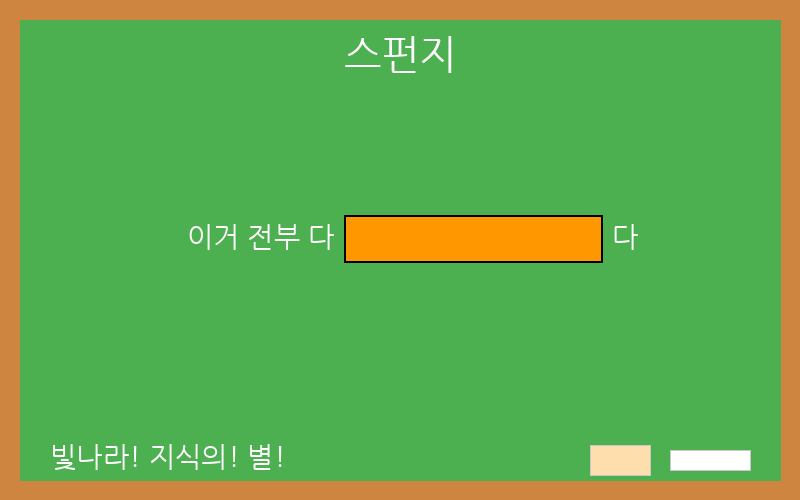

In [4]:
import numpy as np
import imageio
from PIL import Image, ImageDraw, ImageFont
import os
import tempfile
import re
import platform
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def create_sponge_animation(pre_text, blank_text, post_text,
                           output_filename="sponge_animation.gif",
                           font_size=28, title_font_size=40,   # 폰트사이즈
                           width=800, height=500,    #높이, 너비
                           bg_color=(76, 175, 80),  # 초록색 배경
                           text_color=(255, 255, 255),  # 흰색 글씨
                           box_color=(255, 152, 0),  # 주황색 박스
                           box_text_color=(0, 0, 0),  # 검은색 텍스트
                           font_path=None, duration=0.7,
                           title="스펀지"):
    """
    스펀지 프로그램 스타일의 퀴즈 애니메이션을 생성하긩~

    Args:
        pre_text (str): 빈칸 이전 텍스트
        blank_text (str): 빈칸에 들어갈 텍스트
        post_text (str): 빈칸 이후 텍스트
        output_filename (str): 출력 GIF 파일명
        font_size (int): 폰트 크기
        title_font_size (int): 제목 폰트 크기
        width (int): 이미지 너비
        height (int): 이미지 높이
        bg_color (tuple): 배경 색상 (R, G, B)
        text_color (tuple): 텍스트 색상 (R, G, B)
        box_color (tuple): 박스 색상 (R, G, B)
        box_text_color (tuple): 박스 내 텍스트 색상 (R, G, B)
        font_path (str): 사용할 폰트 파일 경로
        duration (float): 프레임 간 지속 시간(초)
        title (str): 상단에 표시할 제목
    """
    # 임시 폴더 생성
    temp_dir = tempfile.mkdtemp()

    # 폰트 로드 (한글 지원 폰트)
    try:
        if font_path and os.path.exists(font_path):
            font = ImageFont.truetype(font_path, font_size)
            title_font = ImageFont.truetype(font_path, title_font_size)
            print(f"폰트 로드 성공: {font_path}")
        else:
            # 기본 폰트 사용 (한글 지원 안될 수 있음)
            print("지정된 폰트 경로가 없습니다. 기본 폰트를 사용합니다.")
            font = ImageFont.load_default()
            title_font = ImageFont.load_default()
    except Exception as e:
        print(f"폰트 로드 중 오류 발생: {e}")
        font = ImageFont.load_default()
        title_font = ImageFont.load_default()

    # 빈칸 크기 계산 (빈칸 텍스트의 길이에 따라)
    test_img = Image.new('RGB', (width, height), color=bg_color)
    test_draw = ImageDraw.Draw(test_img)
    blank_bbox = test_draw.textbbox((0, 0), blank_text, font=font)
    blank_width = blank_bbox[2] - blank_bbox[0] + 40  # 여백 추가
    blank_height = blank_bbox[3] - blank_bbox[1] + 20  # 여백 추가

    # 프레임 생성
    frames = []

    # 초기 상태부터 모든 글자가 공개되는 상태까지
    for i in range(len(blank_text) + 1):
        # 현재까지 공개된 글자
        current_revealed = blank_text[:i]
        blank_spaces = " " * (len(blank_text) - i)

        # 이미지 생성
        img = Image.new('RGB', (width, height), color=bg_color)
        draw = ImageDraw.Draw(img)

        # 경계선 그리기 (나무 프레임 효과)
        border_width = 20
        wood_color = (205, 133, 63)  # 나무색
        draw.rectangle([(0, 0), (width, height)], outline=wood_color, width=border_width)

        # SPONGE 타이틀 그리기
        title_bbox = draw.textbbox((0, 0), title, font=title_font)
        title_width = title_bbox[2] - title_bbox[0]
        draw.text((width//2 - title_width//2, 30), title, font=title_font, fill=text_color)

        # 메인 텍스트 위치 (중앙)
        main_y = height // 2 - 30

        # 이전 텍스트 그리기
        pre_bbox = draw.textbbox((0, 0), pre_text, font=font)
        pre_width = pre_bbox[2] - pre_bbox[0]

        # 빈칸(박스) 위치 계산
        total_text_width = pre_width + blank_width + 20  # 빈칸 후 여백
        start_x = (width - total_text_width) // 2

        # 이전 텍스트 그리기
        draw.text((start_x, main_y), pre_text, font=font, fill=text_color)

        # 빈칸 박스 그리기
        box_x = start_x + pre_width + 10
        box_y = main_y - 5
        draw.rectangle([(box_x, box_y), (box_x + blank_width, box_y + blank_height)],
                      fill=box_color, outline=(0, 0, 0), width=2)

        # 빈칸 내용 그리기
        text_x = box_x + 20
        text_y = main_y

        # 이미 공개된 글자와 하이라이트 처리
        for j in range(len(current_revealed)):
            char = current_revealed[j]
            char_bbox = draw.textbbox((0, 0), char, font=font)
            char_width = char_bbox[2] - char_bbox[0]

            # 글자 그리기
            draw.text((text_x, text_y), char, font=font, fill=box_text_color)
            text_x += char_width + 2  # 글자 간격

        # 이후 텍스트 그리기
        post_x = box_x + blank_width + 10
        draw.text((post_x, main_y), post_text, font=font, fill=text_color)

        # 하단에 푸터 추가
        footer_text = "빛나라! 지식의! 별!"
        footer_y = height - 60
        draw.text((50, footer_y), footer_text, font=font, fill=text_color)

        # 분필 아이콘 추가
        chalk_height = 20
        chalk_width = 80
        chalk_x = width - chalk_width - 50
        chalk_y = height - 50
        draw.rectangle([(chalk_x, chalk_y), (chalk_x + chalk_width, chalk_y + chalk_height)],
                      fill=(255, 255, 255), outline=(200, 200, 200), width=1)

        # 지우개 아이콘 추가
        eraser_height = 30
        eraser_width = 60
        eraser_x = width - eraser_width - 150
        eraser_y = height - 55
        draw.rectangle([(eraser_x, eraser_y), (eraser_x + eraser_width, eraser_y + eraser_height)],
                      fill=(255, 222, 173), outline=(200, 200, 200), width=1)

        # 임시 파일로 저장
        frame_path = os.path.join(temp_dir, f"frame_{i}.png")
        img.save(frame_path)
        frames.append(frame_path)

    # GIF 생성
    images = []
    for frame_path in frames:
        images.append(imageio.imread(frame_path))

    # 마지막 프레임은 더 오래 표시
    durations = [duration] * len(images)
    if durations:
        durations[-1] = 2  # 마지막 프레임은 2초

    # GIF로 결과물 저장하기
    imageio.mimsave(output_filename, images, duration=durations)

    # 임시 파일 정리
    for frame_path in frames:
        os.remove(frame_path)
    os.rmdir(temp_dir)

    print(f"GIF 생성 완료: {output_filename}")
    return output_filename

# Colab에서 사용하는 예시
if __name__ == "__main__":
    # 폰트 경로 설정 (Colab 환경에 맞춰 나눔고딕 폰트 경로 지정)
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

    # 3. 사용자 입력 받기
    pre_text = input("빈칸 앞에 올 텍스트를 입력하세요: ")
    blank_text = input("빈칸에 들어갈 텍스트를 입력하세요: ")
    post_text = input("빈칸 뒤에 올 텍스트를 입력하세요: ")

    # 4. GIF 생성
    output_file = create_sponge_animation(
        pre_text,
        blank_text,
        post_text,
        output_filename="sponge_quiz_result.gif",
        font_path=font_path
    )

    # IPython 라이브러리를 이용해서 Google Colab에서 생성된 GIF 파일 보기
    try:
        from IPython.display import Image as IPImage
        from IPython.display import display

        print("생성된 GIF 미리보기:")
        display(IPImage(output_file))


    except:
        print(f"GIF 파일이 {output_file}에 저장되었습니다.")
